# Wind data recipes

A collection of recipes for loading and visualizing wind records in the Salish Sea region.

***

Data loading is done using two functions defined in `salishsea_tools.wind_tools`

   * `get_EC_observations(station_name, start, end)`
       * Loads monthly EC station data from http://climate.weather.gc.ca/historical_data/search_historic_data_e.html
       * `station_name` mappings are defined in the function, consistent with `salishsea_tools.places`
       * `start` and `end` must be in the same calendar month
   * `read_DFO_buoy(station_name, year)`
       * Loads yearly DFO buoy files from http://www.meds-sdmm.dfo-mpo.gc.ca/isdm-gdsi/waves-vagues/data-donnees/index-eng.asp

HRDPS is loaded from the SalishSeaCast erddap archive https://salishsea.eos.ubc.ca/erddap

Windrose plots made using the Windrose library:

https://windrose.readthedocs.io/en/latest/

`$ pip install windrose`

In [2]:
import xarray as xr
import numpy as np
from datetime import datetime
from calendar import monthrange
from matplotlib import pyplot as plt, colors
from windrose import WindroseAxes
from cmocean import cm as cmo
from tqdm.notebook import tqdm
from salishsea_tools import wind_tools, places, viz_tools

%matplotlib inline

In [3]:
plt.rcParams['font.size'] = 14

***

## Basic examples

We'll look at the month of January, 2019

In [136]:
# Define timerange
timerange = [datetime(2019, 1, 1), datetime(2019, 1, 31)]

### Functions

Define functions for loading HRDPS and plotting wind time series.

In [116]:
def load_HRDPS(station, timerange):
    """Load HRDPS time series at STATION over TRANGE
    """

    # Read HRDPS from erddap
    j, i = places.PLACES[station]['HRDPS grid ji']
    u, v = [HRDPS.sel(time=slice(*timerange))[key][:, j, i].values for key in ['u_wind', 'v_wind']]

    # Calculate wind speed
    wspd = np.sqrt(u**2 + v**2)

    # Calculate wind direction
    wdir = 180 * np.arctan2(v, u) / np.pi
    wdir[wdir < 0] = wdir[wdir < 0] + 360

    # Format time to datetime.datetime
    time = HRDPS.sel(time=slice(*timerange)).time.values.astype('datetime64[s]').astype(datetime)
    
    return wspd, wdir, time


def plot_timeseries(station, time_obs, time_HRDPS, wspd_obs, wspd_HRDPS, wdir_obs, wdir_HRDPS):
    """Plot timeseries
    """
    
    # Plot timeseries
    fig, axs = plt.subplots(2, 1, figsize=(17, 6))
    for ax in axs:
        ax.set_xlim([time_HRDPS[0], time_HRDPS[-1]])

    # Upper panel: wind speed
    axs[0].plot(time_obs, wspd_obs, 'k-', label='obs')
    axs[0].plot(time_HRDPS, wspd_HRDPS, 'r-', label='HRDPS')
    axs[0].set_ylim([0, 17])
    axs[0].set_ylabel('speed [m/s]')
    axs[0].xaxis.set_ticklabels('')
    axs[0].set_title(time_HRDPS[0].strftime('%B %Y') + ' surface wind at ' + station)
    axs[0].legend()

    # Lower panel: wind direction
    axs[1].plot(time_obs, wdir_obs, 'k-')
    axs[1].plot(time_HRDPS, wdir_HRDPS, 'r-')
    axs[1].set_ylim([0, 360])
    axs[1].set_ylabel('dir [$^{\circ}$CCW from E]')
    
    return fig, axs

### Example 1: EC station data

EC station Sand Heads

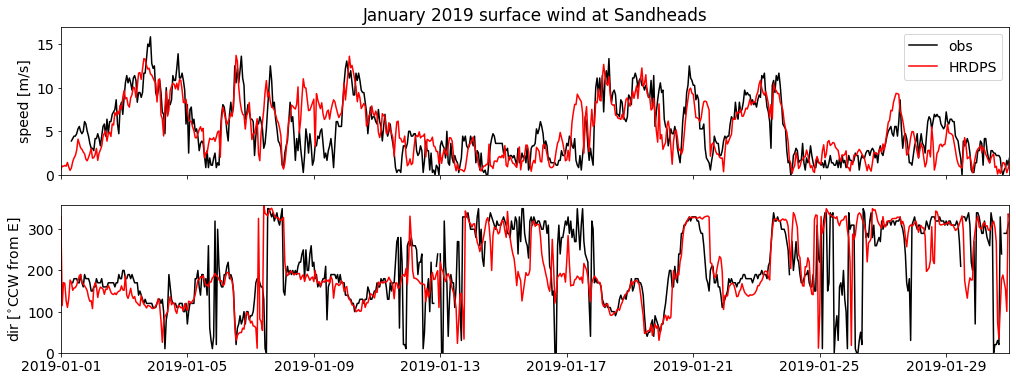

In [143]:
# Specify station and time range
station = 'Sandheads'

# Get EC station observations
# Must be within a single calendar month. Date string format is specific.
start, end = [t.strftime('%d-%b-%Y') for t in timerange]
wspd_obs, wdir_obs, temp, time_obs, lat, lon = wind_tools.get_EC_observations(station, start, end)

# Get HRDPS record from erddap
wspd_HRDPS, wdir_HRDPS, time_HRDPS = load_HRDPS(station, timerange)

# Plot time series
fig, axs = plot_timeseries(station, time_obs, time_HRDPS, wspd_obs, wspd_HRDPS, wdir_obs, wdir_HRDPS)

### Example 2: DFO buoy data

DFO station Sentry Shoal

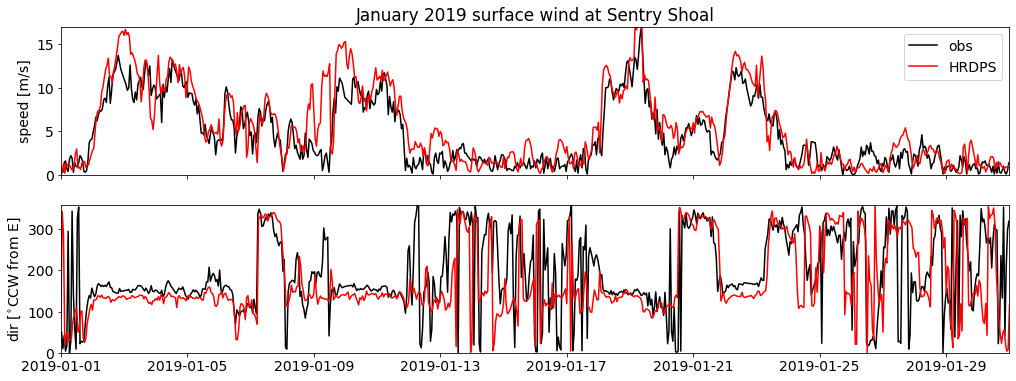

In [142]:
# Specify station and time range
station = 'Sentry Shoal'

# Get DFO buoy observations
# Loaded as yearly file
wspd_obs, wdir_obs, time_obs = wind_tools.read_DFO_buoy(station, 2019)

# Get HRDPS record from erddap
wspd_HRDPS, wdir_HRDPS, time_HRDPS = load_HRDPS(station, timerange)

# Plot time series
fig, axs = plot_timeseries(station, time_obs, time_HRDPS, wspd_obs, wspd_HRDPS, wdir_obs, wdir_HRDPS)

### Example 3: Windrose plots

The default formatting of these is usually poor, so I add quite a bit of customization to the axes and legend.

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


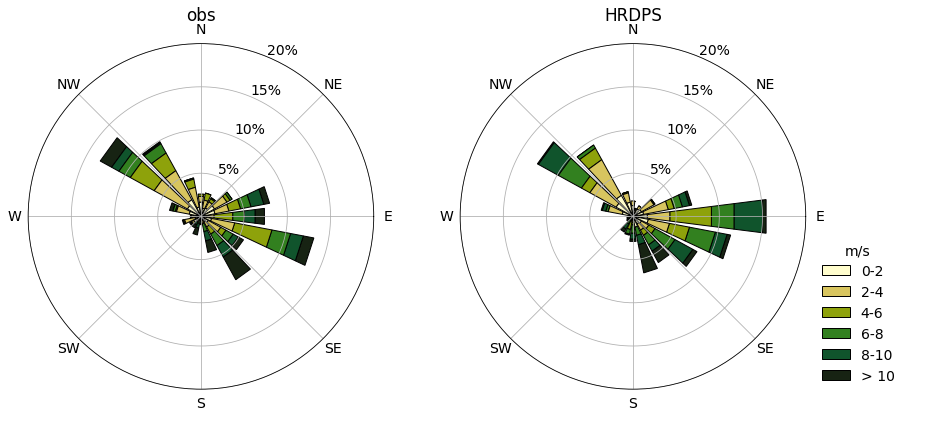

In [144]:
# Make figure
fig = plt.figure(figsize=(12, 6))

# Loop through obs/HRDPS
for wspd, wdir, title, xpos in zip([wspd_obs, wspd_HRDPS], [wdir_obs, wdir_HRDPS], ['obs', 'HRDPS'], [0, 0.5]):

    # Make windrose object
    ax = WindroseAxes.from_ax(fig=fig)
    ax.set_position([xpos, 0.15, 0.4, 0.8])

    # Translate angle to CW from N
    angle = 270 - wdir
    angle[angle < 0] = angle[angle < 0] + 360
    
    # Plot windrose
    ax.bar(angle, wspd, bins=range(0, 11, 2), nsector=20, normed=True, opening=0.8, edgecolor='k', cmap=cmo.speed)

    # Formatting
    ax.set_ylim([0, 20])
    ax.yaxis.set_ticks([5, 10, 15, 20])
    ax.yaxis.set_ticklabels('')
    ax.xaxis.set_ticklabels('')
    ax.xaxis.set_ticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'])
    ax.yaxis.set_ticklabels([f'{tick}%' for tick in [5, 10, 15, 20]])
    ax.set_title(title)
    
    # Manually get legend handles (since WindroseAxes.bar returns None)
    handles = ax.get_children()[:6]

# Add legend
labels = ['0-2', '2-4', '4-6', '6-8', '8-10', '> 10']
fig.legend(frameon=False, handles=handles, labels=labels, bbox_to_anchor=(1.05, 0.45), title='m/s')

plt.show()

***

## Full wind analysis

Preliminary definitions

In [4]:
# NetCDF objects from erddap
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
mask = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02')

# Station names (in order along thalweg from N)
station_names = [
    'Sentry Shoal', 'Comox Airport', 'Sisters Islet', 'Ballenas Islands', 'Entrance Island',
    'Halibut Bank', 'Pam Rocks', 'Point Atkinson', 'YVR', 'Sandheads',
    'Tsawwassen', 'Saturna Island', 'Discovery Island', 'Esquimalt', 'Race Rocks',
]

# Initialize stations dict
stations = {}
for name in station_names:
    stations[name] = {'ji': []}
    for key in ['obs', 'HRDPS']:
        stations[name][key] = {'wspd': np.empty(0), 'wdir': np.empty(0), 'time': np.empty(0)}

### Read data

5 years $\times$ 15 stations = approximately 3 hours on salish

In [7]:
# Define concatenation function
def append_variables(data, variables):
    for key, var in zip(['wspd', 'wdir', 'time'], variables):
        data[key] = np.hstack((data[key], var))

# Loop through years
for y in tqdm(range(2015, 2020)):
    
    # Loop through stations
    for station in station_names:
        
        # Read HRDPS from erddap (whole year)
        wspd, wdir, time = load_HRDPS(station, [datetime(y, 1, 1), datetime(y, 12, 31, 23)])
        append_variables(stations[station]['HRDPS'], [wspd, wdir, time])
        
        # Read DFO data (whole year)
        if station in ['Halibut Bank', 'Sentry Shoal']:
            wspd, wdir, time = wind_tools.read_DFO_buoy(station, y)
            append_variables(stations[station]['obs'], [wspd, wdir, time])
        
        # Read EC data (month by month)
        else:
            for m in range(1, 13):
                trange = [datetime(y, m, d).strftime('%d-%b-%Y') for d in [1, monthrange(y, m)[1]]]
                wspd, wdir, _, time, _, _ = wind_tools.get_EC_observations(station, *trange)
                append_variables(stations[station]['obs'], [wspd, wdir, time])

### Plot station locations

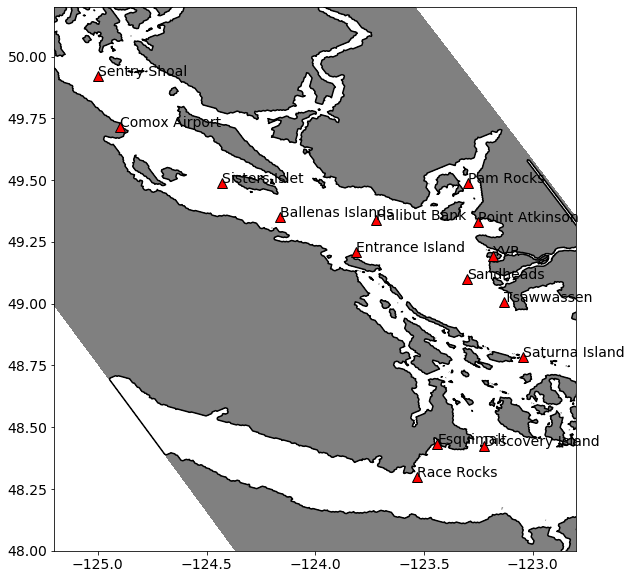

In [48]:
# Make figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot map
ax.contourf(mask.glamt[0, ...], mask.gphit[0, ...], mask.tmaskutil[0, ...], levels=[-0.01, 0.01], colors='gray')
ax.contour(mask.glamt[0, ...], mask.gphit[0, ...], mask.tmaskutil[0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-125.2, -122.8])
ax.set_ylim([48, 50.2])
viz_tools.set_aspect(ax)

# Plot stations
for station in station_names:
    ax.text(*places.PLACES[station]['lon lat'], station)
    ax.plot(*places.PLACES[station]['lon lat'], 'k^', markersize=10, markerfacecolor='r')

### Plot windroses

In order along the thalweg from N

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


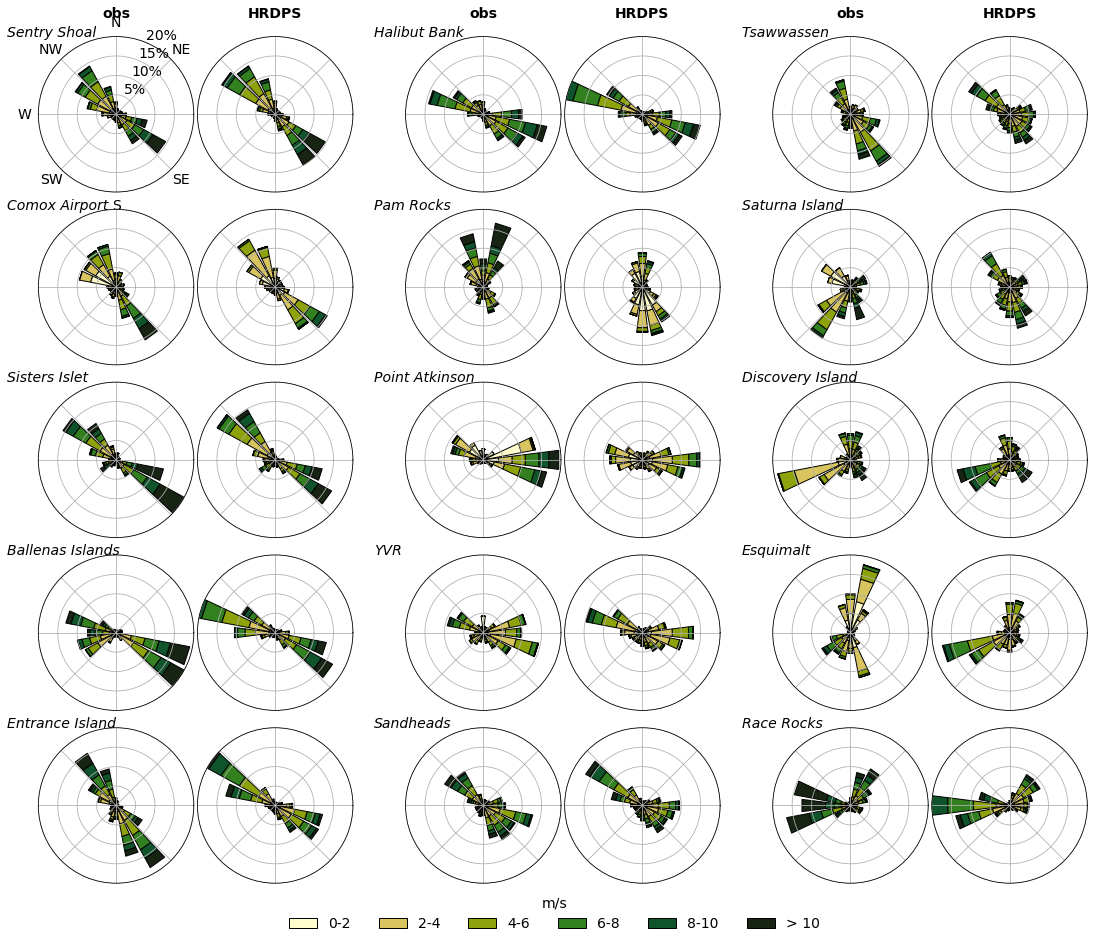

In [147]:
# Make figure
fig = plt.figure(figsize=(17, 12))

# Loop through stations and records
for keys, xpos in zip([station_keys[:5], station_keys[5:10], station_keys[10:15]], [0, 0.3, 0.6]):
    for station, ypos in zip(keys, [0.85, 0.65, 0.45, 0.25, 0.05]):
        for record, xshift in zip(['obs', 'HRDPS'], [0, 0.13]):

            # Make windrose object
            ax = WindroseAxes.from_ax(fig=fig)
            ax.set_position([xpos+xshift, ypos, 0.15, 0.18])

            # Plot wind data
            angle = 360 - stations[station][record]['wdir'] - 90
            angle[angle < 0] = angle[angle < 0] + 360
            ax.bar(
                angle, stations[station][record]['wspd'], bins=range(0, 11, 2),
                nsector=20, normed=True, opening=0.8, edgecolor='k', cmap=cmo.speed,
            )
            
            # Manually get legend handles (since WindroseAxes.bar returns None)
            handles = ax.get_children()[:6]

            # Formatting axis
            ax.set_ylim([0, 20])
            ax.yaxis.set_ticks([5, 10, 15, 20])
            ax.yaxis.set_ticklabels('')
            ax.xaxis.set_ticklabels('')
            if record == 'obs':
                ax.text(-0.2, 1, station, transform=ax.transAxes, fontdict={'style': 'italic'})
                if station == 'Sentry Shoal':
                    ax.xaxis.set_ticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'])
                    ax.yaxis.set_ticklabels([f'{tick}%' for tick in [5, 10, 15, 20]])
            if station in ['Sentry Shoal', 'Halibut Bank', 'Tsawwassen']:
                ax.text(0.5, 1.12, record, transform=ax.transAxes, ha='center', fontdict={'weight': 'bold'})

# Add legend
labels = ['0-2', '2-4', '4-6', '6-8', '8-10', '> 10']
fig.legend(frameon=False, handles=handles, labels=labels, bbox_to_anchor=(0.68, 0.06), ncol=6, title='m/s')

plt.show()